## Introducción a PyTorch (Parte 5)

<a target="_blank" href="https://colab.research.google.com/github/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Introducci%C3%B3n%20a%20PyTorch%20(Parte%205).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

En este notebook vamos a utilizar los conocimientos aprendidos en los notebooks anteriores para realizar un entrenamiento más avanzando. En particular aprenderemos lo siguiente:
- Carga de un dataset.
- Particionado de los datos.
- Creación de los DataLoaders.
- Bucle de entrenamiento, validación y early stopping.
- Salvar el modelo y checkpoints intermedios. Carga de modelos.
- Inferencia.

Trabajaremos en este caso con el conjunto FashionMNIST, un conjunto con **10 clases**, 60.000 ejemplos de entrenamiento y 10.000 ejemplos para test.

### Carga de los datos
Procederemos igual que en la práctica anterior:

In [17]:
import torch
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

print("Datos de entrenamiento:")
print(training_data, end='\n\n')
print("Datos de test:")
print(test_data, end='\n\n')

# Separación de un conjunto de validación
training_data, validation_data = random_split(training_data,(50000,10000))

Datos de entrenamiento:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Datos de test:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()



### Visualización de los datos

Visualizamos algunos datos para ver como son las imágenes:

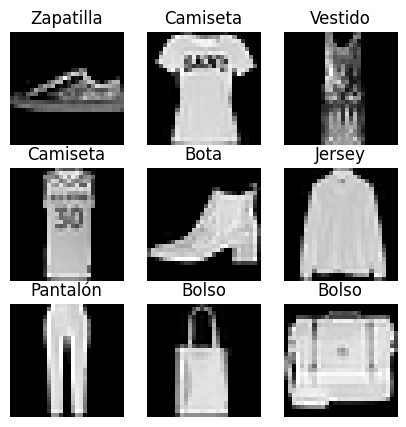

In [18]:
labels_map = {
    0: "Camiseta",
    1: "Pantalón",
    2: "Jersey",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Zapatilla",
    8: "Bolso",
    9: "Bota",
}

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creación de los DataLoaders

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

### Definición de la red
En este caso utilizaremos de nuevo una red totalmente conectada, aunque sería más adecuado utilizar una red convolucional para mejorar el rendimiento del sistema.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, dropout=0.2, linear_sizes = (50, 50, 10)):
        super(Net, self).__init__()
        self.layers = nn.Sequential()
        previous_size = 28*28 # la entrada tienen que coincidir con el número de pixeles en la imagen
        for i, linear_size in enumerate(linear_sizes):
            self.layers.append(nn.Linear(previous_size, linear_size))
            if i != len(linear_sizes):
                # Añadir dropout salvo en la última capa de salida
                self.layers.append(nn.Dropout(dropout))
            previous_size = linear_size

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.layers(x)
        

### Creación de los bucles de validación y entrenamiento

In [26]:
from tqdm.notebook import tqdm 

def train_model(model, optimizer, data_loader, loss_module, num_epochs=1000):
    # Set model to train mode
    model.train()

    # Training loop
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        epoch_loss = 0
        for data_inputs, data_labels in data_loader:
            #Hacer una pasada hacia delante
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]
            #Calcular el valor de la función de pérdida para este mini-batch
            loss = loss_module(preds, data_labels)
            #Acumular el error (solo para luego mostrarlo)
            epoch_loss += loss.item()
            #Reiniciar los gradientes
            optimizer.zero_grad()
            #Pasada hacia atrás
            loss.backward()
            #Actualizar los parámetros
            optimizer.step()
        #Imprimir el error cada 50 épocas
        if epoch%50==0:
            pbar.set_description("Loss %0.2f" % epoch_loss)


In [27]:
model = Net(dropout=0.2, linear_sizes=(50,50,10))
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss = nn.CrossEntropyLoss()
train_model(model, optimizer, train_dataloader, loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 